### Only Retweets Network

##### Settings

In [1]:
from pathlib import Path
import tempfile
import os
import pandas as pd

TMP_DIR = Path(tempfile.gettempdir())
tmp_file = TMP_DIR / "search.json"


##### Search Function

In [2]:

def search_tweets(
    search, type_search = "" , since=None, maxresults=None, output_json = tmp_file, min_retweets=0
):
    """
    Search and download all tweets containing a specific hashtag 
    Use https://github.com/igorbrigadir/twitter-advanced-search to get a better idea of the parameters you 
    can use in your research
    """
    cmd = 'snscrape --with-entity  %s  %s --jsonl twitter-search {search} > {outputjson}'.format(
        outputjson = output_json,
        search = '"+%s %s min_retweets:%s"' % (search, type_search, str(min_retweets))
    ) % (
        "--max-results {maxresults}".format(maxresults = maxresults) if maxresults else "", 
        "--since {since}".format(since = since) if since else "", 
    )
    print(cmd)
    os.system(cmd)

##### Launch Search

In [2]:
search_tweets(
    search = "#DébatLR",
    type_search= "filter:nativeretweets",
    min_retweets = 0,
    since = "2021-11-18",
    maxresults = None
)

snscrape --with-entity    --since 2021-11-18 --jsonl twitter-search "+#DébatLR filter:nativeretweets min_retweets:0" > /tmp/search.json


#### Nodes

#### Create dataframe from tweets

In [4]:
tweets = pd.read_json(tmp_file, lines=True)

In [ ]:
import tweepy

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(key, secret)

api = tweepy.API(auth)

public_tweets = api.search("stackoverflow")
for tweet in public_tweets:
    print api.retweets(tweet.id)

#### Edges

##### Create dataframe from tweets

In [2]:
def extract_edges(path_tmp_file = tmp_file, source_column = "id_source", target_column = "id_target"):
    """
    Extract edges to draw network from list of tweets (edges are thus based on retweets)
    """
    #load tweets
    tweets = pd.read_json(path_tmp_file, lines=True)
    if len(tweets):
        #get target and source of each rt
        tweets[source_column] = tweets.user.apply(lambda x:x["username"])
        tweets[target_column] = tweets.retweetedTweet.apply(lambda x:x["user"]["username"])
        #keep only relevant columns
        edges = tweets[[source_column, target_column]] 
        #drop people who retweet themselves 
        edges = edges[edges[source_column] != edges[target_column]]
    else:
        raise Exception("no tweets found")
    return edges

In [3]:
edges = extract_edges(tmp_file)

##### Build network


In [4]:
import networkx as nx

layout_functions = {
    "bipartite":nx.bipartite_layout,
    "circular": nx.circular_layout,
    "kamada_kawai": nx.kamada_kawai_layout,
    "planar": nx.planar_layout,
    "random": nx.random_layout,
    "shell": nx.shell_layout,
    "spring": nx.spring_layout,
    "spectral": nx.spectral_layout,
    "spiral": nx.spiral_layout,
    "multipartite": nx.multipartite_layout
}

def return_nodes_position(edges_df, type_position_algo):
    G = nx.DiGraph()
    G = nx.from_pandas_edgelist(edges_df, source = "id_source", target = "id_target")
    position_function = layout_functions[type_position_algo]
    position = position_function(G)
    return position

##### Compute position

In [5]:
algo = "spring"

In [11]:
position = return_nodes_position(
edges_df = edges, 
type_position_algo = algo)

##### Plot

In [12]:
G = nx.DiGraph()
G = nx.from_pandas_edgelist(edges, source = "id_source", target = "id_target")

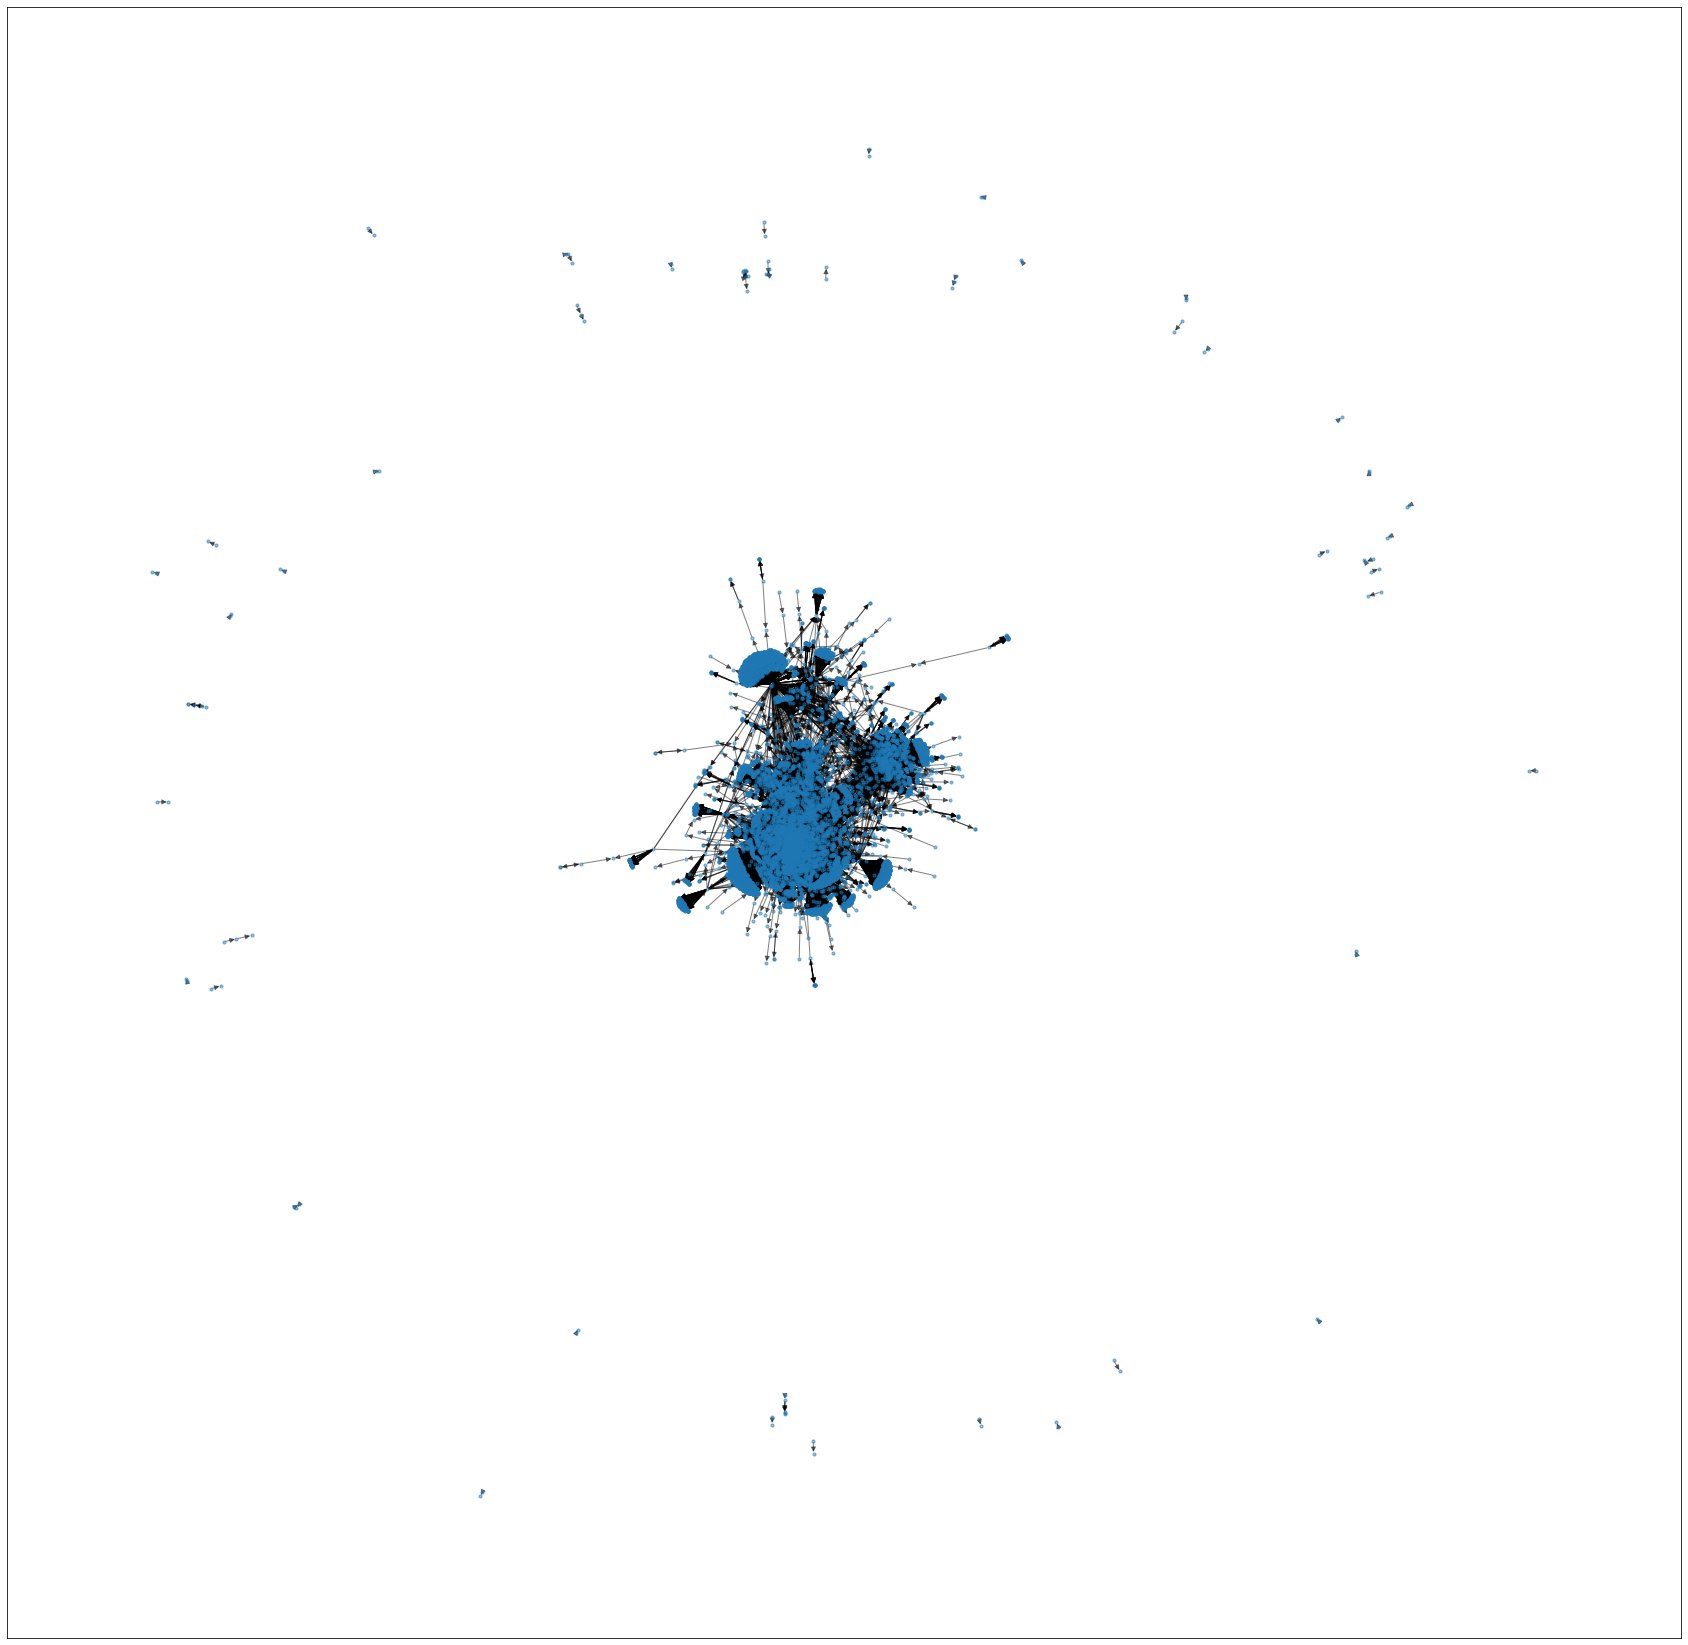

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
nx.draw_networkx(
    G, pos=position, arrows = True, with_labels = False, font_size = 15, node_size = 10, alpha = 0.5

                )